In [1]:
# Training variables
rolling_mean = 30

## Import data from AWS S3

In [2]:
import sys
sys.path.insert(0, '/home/khiem/Dropbox/Education/Drexel/DSCI-591/Project/Walmart-Strategic-Sales-Forecasting')

In [3]:
import boto3
import pandas as pd

bucket = 'dsci-632'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket="dsci-632", Key="CA_1_sales_data.csv")
df = pd.read_csv(obj['Body'], index_col=0, parse_dates=True) # 'Body' is a keyword
print(df.head())

            wm_yr_wk  wday  month  year event_name_1 event_type_1  \
2011-01-29     11101     1      1  2011         None         None   
2011-01-30     11101     2      1  2011         None         None   
2011-01-31     11101     3      1  2011         None         None   
2011-02-01     11101     4      2  2011         None         None   
2011-02-02     11101     5      2  2011         None         None   

           event_name_2 event_type_2      cpi  unemployment_rate  gas_price  \
2011-01-29         None         None  221.187                9.1      3.163   
2011-01-30         None         None  221.187                9.1      3.163   
2011-01-31         None         None  221.187                9.1      3.155   
2011-02-01         None         None  221.898                9.0      3.155   
2011-02-02         None         None  221.898                9.0      3.155   

            snap_ca  ca_walmart  ca_hobbies  ca_household  ca_foods  \
2011-01-29        0       39.50       2

## Data Processing

In [4]:
from data_processing.pre_modeling import pre_modeling

df_processed = pre_modeling(df)

## Data Analysis

In [5]:
timeseries_cols = ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price']
time_cols = ['wm_yr_wk', 'wday', 'day', 'month', 'year']
target_col = ['store_sales']
cat_cols = [col for col in df_processed.columns if col not in timeseries_cols + time_cols + target_col] # extract the remaining columns

In [6]:
df_used = df_processed[timeseries_cols+time_cols+cat_cols+target_col]
df_used = df_used.rolling(rolling_mean).mean().dropna()

In [7]:
nobs = 30
df_original = df_used
df_test = df_used[-nobs:]
df_train = df_used[0:-nobs]

print(df_train.columns)

Index(['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies',
       'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price',
       'wm_yr_wk', 'wday', 'day', 'month', 'year', 'snap_ca',
       'event_name_1_chanukah end', 'event_name_1_christmas',
       'event_name_1_cinco de mayo', 'event_name_1_columbusday',
       'event_name_1_easter', 'event_name_1_eid al-fitr',
       'event_name_1_eidaladha', 'event_name_1_father's day',
       'event_name_1_halloween', 'event_name_1_independenceday',
       'event_name_1_laborday', 'event_name_1_lentstart',
       'event_name_1_lentweek2', 'event_name_1_martinlutherkingday',
       'event_name_1_memorialday', 'event_name_1_mother's day',
       'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart',
       'event_name_1_newyear', 'event_name_1_none',
       'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster',
       'event_name_1_pesach end', 'event_name_1_presidentsday',
       'event_name_1_purim 

In [8]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value > sig:
        return True
    else:
        return False

def adfuller_test_all(df, sig=0.05):
    non_stationary = []
    stationary = []
    for name, column in df_train.iteritems():
        if adfuller_test(column, name=column.name):
            non_stationary.append(column.name)
        else:
            stationary.append(column.name)

    print('Non-stationary:', non_stationary)
    print('Stationary:', stationary)

adfuller_test_all(df_train)

Non-stationary: ['cpi', 'unemployment_rate', 'gas_price', 'median_price', 'min_price', 'max_price', 'wm_yr_wk', 'year', 'store_sales']
Stationary: ['ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'wday', 'day', 'month', 'snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 

In [9]:
df_train = df_train.diff().dropna()
adfuller_test_all(df_train)

Non-stationary: []
Stationary: ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods', 'median_price', 'min_price', 'max_price', 'wm_yr_wk', 'wday', 'day', 'month', 'year', 'snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 'event_name_1

In [10]:
from statsmodels.tsa.api import VAR

df_train_fit = df_train[timeseries_cols+target_col]
model = VAR(df_train_fit)
x = model.select_order(maxlags=12)
x.summary()

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-66.03,-65.99,2.114e-29,-66.01
1,-83.58,-83.19,5.010e-37,-83.44
2,-84.25,-83.50*,2.570e-37,-83.98
3,-84.41,-83.30,2.204e-37,-84.00
4,-84.73,-83.27,1.589e-37,-84.19
5,-84.78,-82.95,1.523e-37,-84.10
6,-85.10,-82.92,1.103e-37,-84.29
7,-85.37,-82.83,8.415e-38,-84.43
8,-86.06,-83.16,4.203e-38,-85.00*
9,-86.03,-82.77,4.360e-38,-84.83


In [11]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Jul, 2022
Time:                     00:03:41
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                   -82.7966
Nobs:                     1874.00    HQIC:                  -84.3975
Log likelihood:           51563.3    FPE:                8.73737e-38
AIC:                     -85.3312    Det(Omega_mle):     5.57915e-38
--------------------------------------------------------------------
Results for equation cpi
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000654         0.000150            4.347           0.000
L1.cpi                       0.718589         0.024238           29.647           0.000
L1.unemployment_rate        -0.273

In [12]:
print(model_fitted.params["store_sales"])

const                      0.253579
L1.cpi                   -64.374652
L1.unemployment_rate     118.660971
L1.gas_price             123.192064
L1.ca_walmart              5.918974
                           ...     
L7.ca_foods               -8.778338
L7.median_price         3673.676152
L7.min_price           -1600.180635
L7.max_price             -21.111276
L7.store_sales             0.432124
Name: store_sales, Length: 78, dtype: float64


In [13]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_train_fit.values[-lag_order:]
forecast_input

7


array([[ 3.04000000e-02,  3.33333333e-03,  3.70000000e-03,
         4.56000000e-01,  1.01333333e-01, -2.20666667e-01,
         4.65333333e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.02666667e+01],
       [ 3.04000000e-02,  3.33333333e-03,  3.70000000e-03,
         4.92000000e-01, -3.82666667e-01,  2.13333333e-02,
         4.12333333e-01,  4.44089210e-16,  0.00000000e+00,
         7.10542736e-15,  5.56333333e+01],
       [ 3.04000000e-02,  3.33333333e-03,  5.93333333e-03,
         7.20000000e-02, -2.49333333e-01,  8.48333333e-01,
         6.37000000e-01,  0.00000000e+00, -2.77555756e-17,
        -7.10542736e-15, -4.38000000e+01],
       [ 3.04000000e-02,  3.33333333e-03,  5.93333333e-03,
         1.20000000e-02, -2.10000000e-01,  1.30333333e-01,
         7.51333333e-01, -4.44089210e-16,  2.77555756e-17,
         0.00000000e+00, -8.01333333e+01],
       [ 3.04000000e-02,  3.33333333e-03,  4.36666667e-03,
         2.28000000e-01, -6.18666667e-01, -1.34666667e-01,
  

In [14]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_original.index[-nobs:], columns=df_train_fit.columns + '_1d')
df_forecast["store_sales_1d"]

2016-04-23    66.425107
2016-04-24    46.732981
2016-04-25   -40.181155
2016-04-26   -66.159012
2016-04-27   -25.087451
2016-04-28    -3.867678
2016-04-29    20.136684
2016-04-30    62.507528
2016-05-01    42.152628
2016-05-02   -35.211718
2016-05-03   -60.018637
2016-05-04   -27.567759
2016-05-05    -4.770128
2016-05-06    21.808327
2016-05-07    58.007673
2016-05-08    37.605272
2016-05-09   -30.252012
2016-05-10   -54.765178
2016-05-11   -28.886795
2016-05-12    -4.759365
2016-05-13    23.341397
2016-05-14    53.977245
2016-05-15    33.930923
2016-05-16   -26.001454
2016-05-17   -50.127271
2016-05-18   -29.512648
2016-05-19    -4.691016
2016-05-20    24.265878
2016-05-21    50.456794
2016-05-22    30.959975
Name: store_sales_1d, dtype: float64

In [15]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_original[0:-nobs][timeseries_cols+target_col], df_forecast)        
df_results.head(10)

,cpi_1d,unemployment_rate_1d,gas_price_1d,ca_walmart_1d,ca_hobbies_1d,ca_household_1d,ca_foods_1d,median_price_1d,min_price_1d,max_price_1d,...,unemployment_rate_forecast,gas_price_forecast,ca_walmart_forecast,ca_hobbies_forecast,ca_household_forecast,ca_foods_forecast,median_price_forecast,min_price_forecast,max_price_forecast,store_sales_forecast
2016-04-23,0.029551,0.003094,0.004116,0.534361,0.078118,-0.112678,0.363515,0.000089,0.000071,-0.001344,...,5.076427,2.181616,27.942361,29.070452,38.589322,54.585848,3.480089,0.230071,29.968656,4597.991774
2016-04-24,0.030436,0.002541,0.004016,0.507901,0.088063,-0.065897,0.469010,0.000132,0.000092,-0.001187,...,5.078968,2.185632,28.450262,29.158514,38.523426,55.054859,3.480221,0.230163,29.967469,4644.724755
2016-04-25,0.029602,0.002412,0.004118,0.046616,-0.097228,0.069093,0.558813,0.000076,0.000011,0.000146,...,5.081380,2.189750,28.496878,29.061287,38.592519,55.613672,3.480296,0.230174,29.967615,4604.543600
2016-04-26,0.028402,0.002219,0.004129,-0.103639,-0.221792,0.134720,0.477744,0.000078,0.000007,-0.000696,...,5.083600,2.193880,28.393239,28.839495,38.727238,56.091417,3.480374,0.230182,29.966919,4538.384588
2016-04-27,0.028471,0.001795,0.004149,0.080656,-0.144165,-0.042641,0.400804,0.000117,0.000001,0.000092,...,5.085395,2.198028,28.473895,28.695330,38.684598,56.492221,3.480490,0.230183,29.967011,4513.297138
2016-04-28,0.028245,0.001615,0.004248,0.118769,-0.079086,-0.079520,0.323485,0.000130,-0.000035,0.000313,...,5.087010,2.202276,28.592664,28.616244,38.605078,56.815706,3.480621,0.230147,29.967324,4509.429460
2016-04-29,0.028158,0.001397,0.004227,0.164687,-0.058860,-0.060752,0.179994,0.000165,-0.000019,0.000284,...,5.088406,2.206504,28.757351,28.557384,38.544326,56.995700,3.480786,0.230129,29.967608,4529.566144
2016-04-30,0.028241,0.001109,0.004237,0.373005,0.087651,-0.188225,0.162552,0.000199,-0.000018,0.001461,...,5.089515,2.210740,29.130356,28.645035,38.356100,57.158252,3.480985,0.230110,29.969069,4592.073672
2016-05-01,0.028149,0.000902,0.004184,0.335174,0.113326,-0.191338,0.320531,0.000212,-0.000030,0.002162,...,5.090417,2.214924,29.465530,28.758360,38.164762,57.478783,3.481197,0.230080,29.971231,4634.226300
2016-05-02,0.027589,0.000732,0.004051,0.000888,-0.060023,0.042347,0.405049,0.000202,-0.000038,0.001459,...,5.091149,2.218975,29.466418,28.698337,38.207109,57.883831,3.481398,0.230043,29.972689,4599.014583


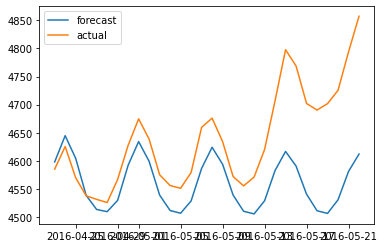

In [16]:
import matplotlib.pyplot as plt

plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()


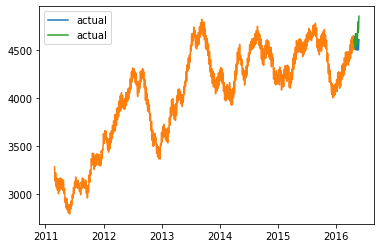

In [17]:
plt.plot(df_results["store_sales_forecast"].index, df_results["store_sales_forecast"], label = "actual")
plt.plot(df_original["store_sales"][0:-nobs].index, df_original["store_sales"][0:-nobs])
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()

In [18]:
# evaluate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

error_mse = mean_squared_error(df_test["store_sales"], df_results["store_sales_forecast"])
error_mae = mean_absolute_error(df_test["store_sales"], df_results["store_sales_forecast"])
error_r2 = r2_score(df_test["store_sales"], df_results["store_sales_forecast"])
print("MSE:", error_mse)
print("MAE:", error_mae)
print("R2:", error_r2)


MSE: 12047.535133360128
MAE: 83.45338561252717
R2: -0.5974140200514597
